## 0. 라이브러리

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as display
import time
np.random.seed(777)

## 1. 데이터 생성
SVM 학습 결과를 시각적으로 확인할 수 있게 하기 위해, 간단한 데이터를 사용할 예정입니다.

데이터는 (x1,x2)로 이루어진 점으로 구성되어 있고, 두개의 클래스 (0,1)로 이루어져 있습니다.

X_train shape : (200, 2)
y_train shape : (200,)


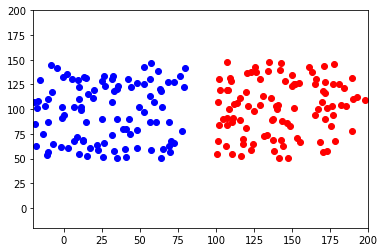

In [2]:
data_num = 100 # 각 클래스의 데이터 개수
blue_center = (30,100) # 1 클래스의 중심 좌표
red_center = (150,100) # 0 클래스의 중심 좌표
d=50 

x1_b = (np.random.uniform(-1,1,data_num)*d+ blue_center[0])[:,np.newaxis]
x2_b = (np.random.uniform(-1,1,data_num)*d+ blue_center[1])[:,np.newaxis]

Xb = np.concatenate((x1_b, x2_b),axis=1)
Yb = np.ones(data_num, dtype='int')

x1_r = (np.random.uniform(-1,1,data_num)*d+ red_center[0])[:, np.newaxis]
x2_r = (np.random.uniform(-1,1,data_num)*d+ red_center[1])[:, np.newaxis]

Xr = np.concatenate((x1_r, x2_r),axis=1)
Yr = np.zeros(data_num, dtype='int')

# concate
X_train = np.concatenate((Xb,Xr))
y_train = np.concatenate((Yb,Yr))

# shuffle
s = np.arange(data_num*2)
np.random.shuffle(s)

X_train = X_train[s]
y_train = y_train[s]

print('X_train shape :',X_train.shape)
print('y_train shape :',y_train.shape)

# iamge
def draw_plot(Xb,Xr,**kwargs):
    x_min = min(Xb[:,0])
    plt.scatter(Xb[:,0],Xb[:,1], color="Blue")
    plt.scatter(Xr[:,0],Xr[:,1], color="Red")
    plt.xlim(-20,200)
    plt.ylim(-20,200)
    
    a = kwargs.get('a')
    b = kwargs.get('b')
    
    if a and b:
        plt.plot(a*np.arange(0,200)+b)
    elif a:
        plt.plot(a*np.arange(0,200))
#     plt.show()

draw_plot(Xb,Xr)
plt.show()

## 2. SVM 모델 정의
cs231n assignment1의 코드를 참조하여 작성하였습니다.

bias의 역할과 svm의 margin의 차이를 알기위해, 두 parameter를 조절할 수 있게 수정하였습니다.

In [3]:
class Linear_classifier(object):
    def __init__(self,margin=1):
        self.W = None
        self.bias = False
        self.margin=margin
        self.W_history = []

    def train(self, X, y, learning_rate=1e-2, reg=1e-7, num_iters=10000,
             batch_size=200, verbose=False, bias = False):
        
        # bias setting
        if bias:
            self.bias = True
            X = np.concatenate([X,np.ones([X.shape[0],1])], axis=1 )
        
        num_train, dim = X.shape
        num_classes = np.max(y) + 1
        
        if self.W is None:
            self.W = 0.001 * np.random.randn(dim, num_classes)
            
        loss_history = []
        for it in range(num_iters):
            X_batch = None
            y_batch = None
            
            batch_indexs = np.random.choice(num_train,batch_size)
            X_batch = X[batch_indexs]
            y_batch = y[batch_indexs]
            
            #eveluate loss and gradient
            loss, grad = self.loss(X_batch, y_batch, reg, delta = self.margin)
            loss_history.append(loss)
            
            # update W
            self.W_history.append(self.W)
            self.W -= learning_rate * grad
            
            if verbose and it%100 == 0:
                print('iteration %d / %d : loss %f' %(it, num_iters, loss))
        
        return loss_history
    
    def predict(self, X):
        
        if self.bias:
            X = np.concatenate([X, np.ones([X.shape[0],1])], axis=1)
        
        y_pred = np.zeros(X.shape[0])
        scores = X.dot(self.W)
        y_pred = np.argmax(scores, axis=1)
        
        return y_pred
    
    def loss(self, X_batch, y_batch, reg):
        pass
    
class LinearSVM(Linear_classifier):
    
    def loss(self, X_batch, y_batch, reg, delta=1):
        Loss = 0.0
        dW = np.zeros_like(self.W)
        
        num_train = X_batch.shape[0]
        
        # calculate svm loss
        scores = X_batch.dot(self.W)
        correct_class_scores = scores[range(num_train), y_batch][:, np.newaxis] # (N,1) shape
        
        margin = np.maximum(0, scores - correct_class_scores + delta)
        margin[range(num_train),y_batch] = 0
        
        Loss = np.sum(margin)
        Loss /= num_train
        Loss += reg*np.sum(self.W*self.W)
        
        # calculate svm gradient
        margin_count = np.zeros(scores.shape)
        margin_count[margin>0] = 1
        margin_count[range(num_train), y_batch] = -np.sum(margin_count, axis=1)
        
        dW = X_batch.T.dot(margin_count)
        
        dW /= num_train
        dW += 2*reg*self.W
        
        return Loss, dW


## 3. Train
간단한 비교를 위해 아래 3가지로 나누어 학습을 진행하였습니다.
- bias가 없는 경우 : svm
- bias가 있는 경우 : svm_bias
- bias가 있고, margin을 변화 시켰을 경우 : svm_margin

In [7]:
print('svm train start')
svm = LinearSVM()
loss_history = svm.train(X_train,y_train, bias=False, num_iters=100000*3)

print('svm_bias train start')
svm_bias = LinearSVM()
loss_history_bias = svm_bias.train(X_train,y_train,bias=True,num_iters=100000*3)

print('svm_margin train start')
mar = 5
svm_margin = LinearSVM(margin=mar)
loss_history_margin = svm_margin.train(X_train, y_train,bias=True, num_iters=100000*3)

print('done')

svm train start
svm_bias train start
svm_margin train start
done


## 4. 시각화
loss의 변화와, W의 상태를 시각화하였습니다.

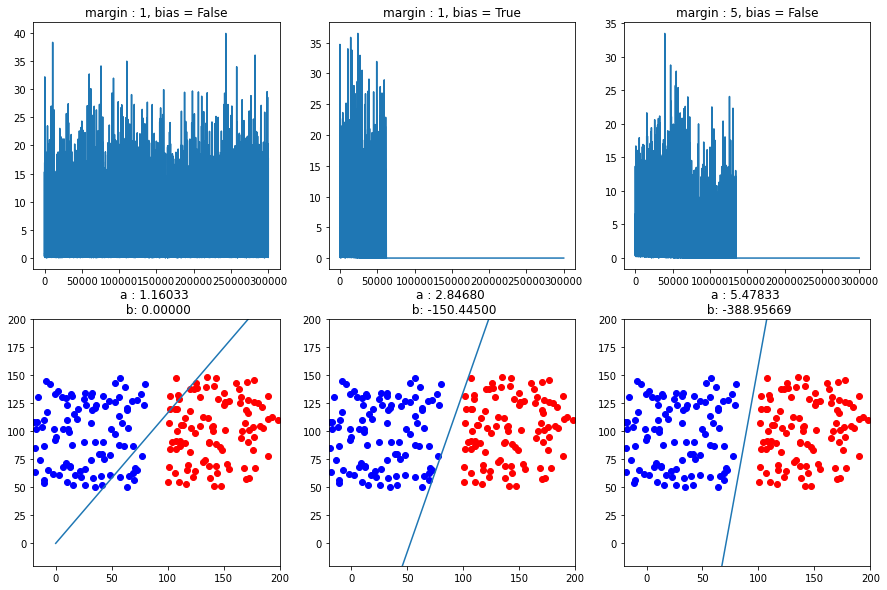

In [8]:
def cal_ab(W):
    '''
        (3,2)shape 혹은 (2,2)shape의 Weights를 2차원 'y = ax + b' 형태로 바꾸기 위한 함수
    '''
    a,b = 0,0
    a = (W[0,0]-W[0,1])/(W[1,1]-W[1,0])
    if W.shape[0] == 3:
        b = (W[2,0]-W[2,1])/(W[1,1]-W[1,0])
    return a,b

plt.figure(figsize=(15,10))

plt.subplot(231)
plt.title("margin : 1, bias = False")
plt.plot(loss_history)

plt.subplot(232)
plt.title("margin : 1, bias = True")
plt.plot(loss_history_bias)

plt.subplot(233)
plt.title("margin : {}, bias = False".format(svm_margin.margin))
plt.plot(loss_history_margin)

a,b = cal_ab(svm.W)
plt.subplot(234)
plt.title('a : %.5f \n b: %.5f'%(a,b))
draw_plot(Xb,Xr,a=a)

a,b = cal_ab(svm_bias.W)
plt.subplot(235)
plt.title('a : %.5f \n b: %.5f'%(a,b))
draw_plot(Xb,Xr, a=a,b=b)

a,b = cal_ab(svm_margin.W)
plt.subplot(236)
plt.title('a : %.5f \n b: %.5f'%(a,b))
draw_plot(Xb,Xr, a=a,b=b)

## 5. margin

##### 5.1 trains
margin의 영향을 자세히 관찰하기 위해, margin 별로 나누어 학습을 관찰.

++ weight inital 고정 추가

In [11]:
margin_list = [1,2,3,4,5,6,7,8,9,10,50,100]
svm_list = []
loss_history_list = []

dim = 3 # bias 추가
num_classes = 2
fixed_W = 0.001 * np.random.randn(dim, num_classes)

for mar in margin_list:
    print('margin : {}, svm train start'.format(mar))
    # SVM create and train
    new_svm = LinearSVM(margin=mar)
    new_svm.W = np.copy(fixed_W)
    loss_history = new_svm.train(X_train,y_train, bias=True, num_iters=500000)
    
    # save the results
    svm_list.append(new_svm)
    loss_history_list.append(loss_history)
print('done')

margin : 1, svm train start
margin : 2, svm train start
margin : 3, svm train start
margin : 4, svm train start
margin : 5, svm train start
margin : 6, svm train start
margin : 7, svm train start
margin : 8, svm train start
margin : 9, svm train start
margin : 10, svm train start
margin : 50, svm train start
margin : 100, svm train start
done


##### 5.2 plot

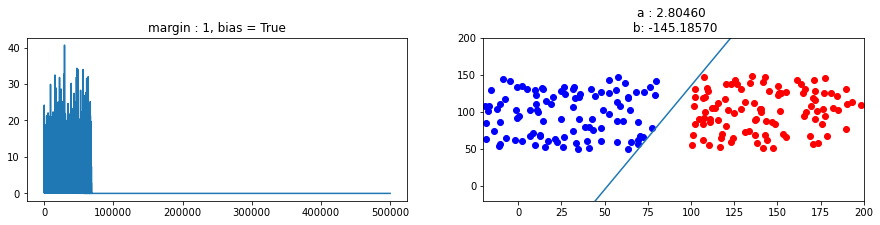

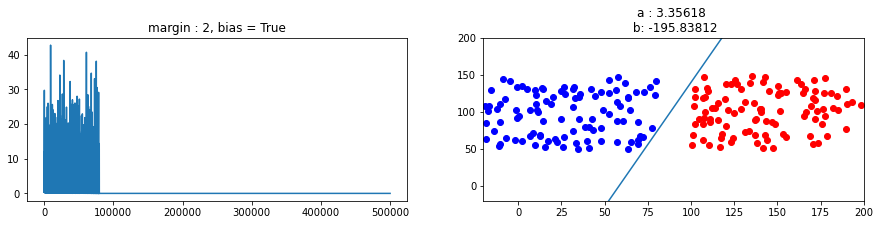

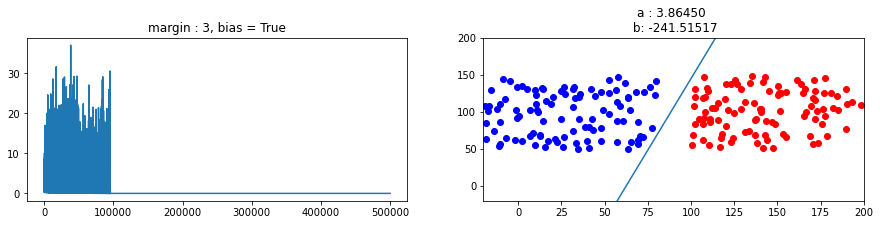

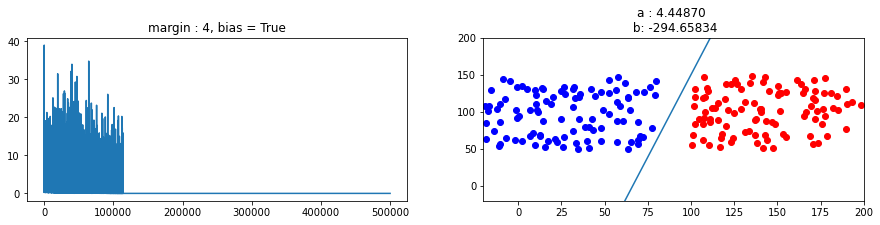

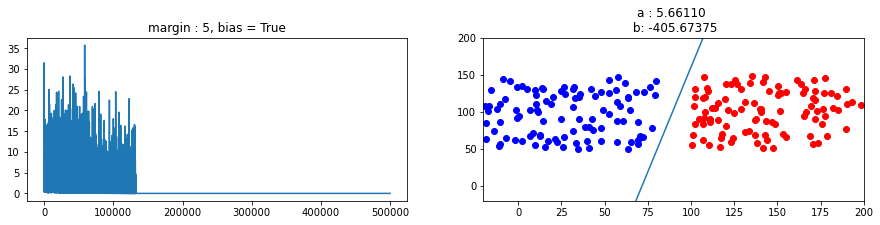

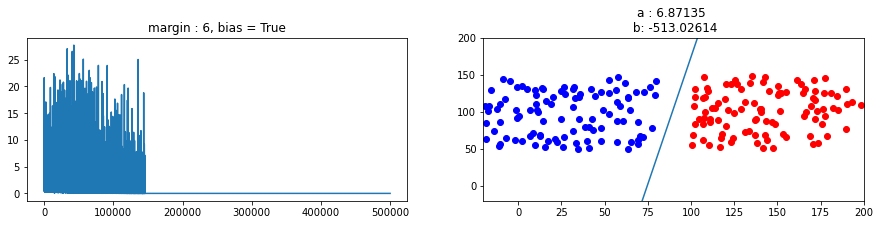

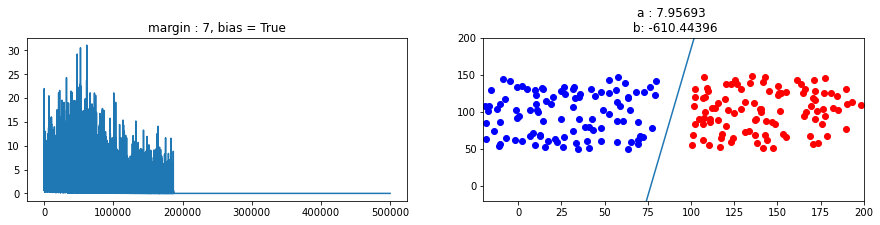

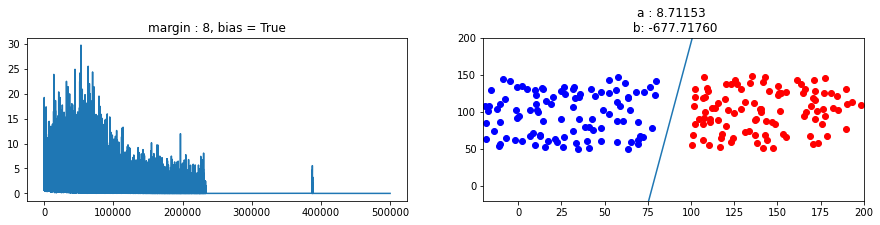

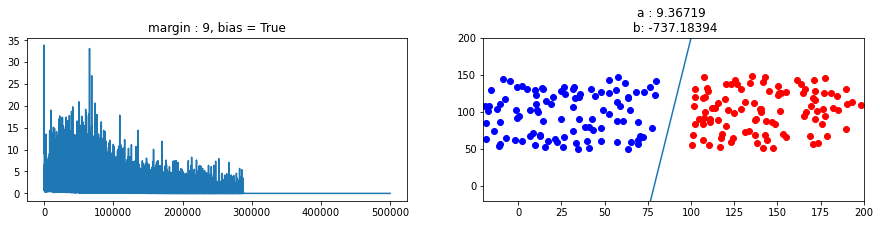

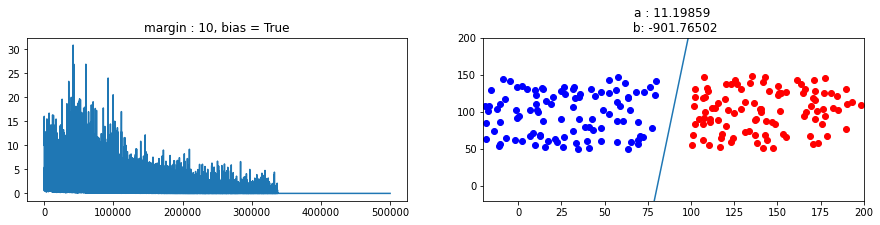

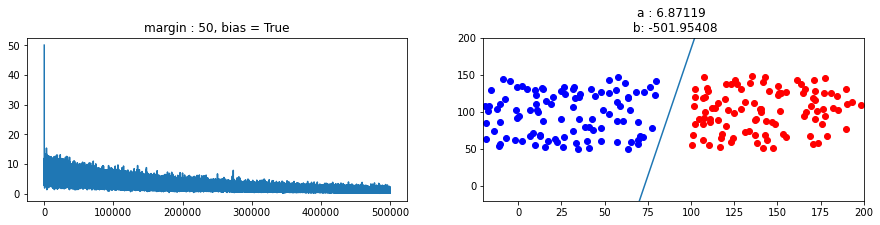

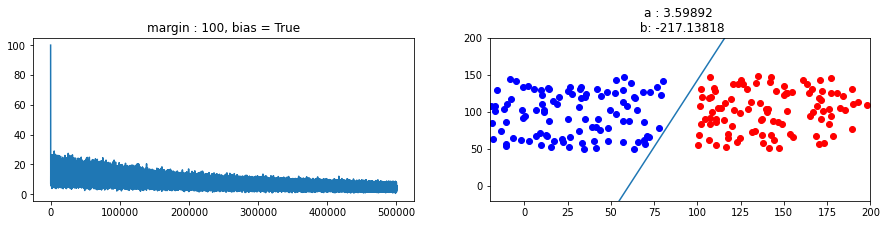

In [12]:
for _svm, _loss in zip(svm_list, loss_history_list):
    plt.figure(figsize=(15,3))
    plt.subplot(1,2,1)
    plt.title("margin : {}, bias = {}".format(_svm.margin, _svm.bias))
    plt.plot(_loss)
    
    a,b = cal_ab(_svm.W)
    plt.subplot(1,2,2)
    plt.title("a : %.5f \n b: %.5f"%(a,b))
    draw_plot(Xb,Xr,a=a,b=b)
    
    plt.show()